# Which car is the best choice for NYPD?

# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.api import OLS, add_constant

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

import kagglehub


# Data preparation

In [2]:
path = kagglehub.dataset_download("geoffnel/evs-one-electric-vehicle-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/apple/.cache/kagglehub/datasets/geoffnel/evs-one-electric-vehicle-dataset/versions/1


In [3]:
data00 = pd.read_csv("ElectricCarData_Clean.csv")

In [4]:
print(data00.columns.tolist())

['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain', 'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro']


In [5]:
data0=data00.fillna('0')

In [6]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    object 
 7   RapidCharge      103 non-null    object 
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 11.4+ KB


# BIC and AIC

In [7]:
# Drop irrelevant columns
data = data0.drop(columns=['Model'])

# Encode categorical variables (e.g., 'Brand', 'RapidCharge', 'PowerTrain', etc.) using one-hot encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Define target (dependent) variables and features (independent variables)
# Here, we are using 'AccelSec' as the target variable for EV performance
y = data_encoded['AccelSec']  # Dependent variable: Acceleration time
X = data_encoded.drop(columns=['AccelSec'])  # Independent variables

# Add a constant term (intercept) to the features
X = add_constant(X)

# Convert boolean columns to integers
X = X.astype({col: 'int' for col in X.select_dtypes(include='bool').columns})
print("Updated X types:")
print(X.dtypes)

Updated X types:
const              float64
TopSpeed_KmH         int64
Range_Km             int64
Efficiency_WhKm      int64
Seats                int64
                    ...   
Segment_D            int64
Segment_E            int64
Segment_F            int64
Segment_N            int64
Segment_S            int64
Length: 109, dtype: object


In [8]:
# Define the backward selection function
def backward_selection(X, y, significance_level=0.05):
    """
    Perform backward selection to identify significant variables based on p-values.
    Variables with p-values greater than the significance level are removed iteratively.
    """
    while True:
        # Fit the Ordinary Least Squares (OLS) model
        model = OLS(y, X).fit()
        # Get p-values for all predictors (excluding intercept)
        p_values = model.pvalues.iloc[1:]  # Exclude the intercept
        max_p_value = p_values.max()  # Find the highest p-value
        # Remove the variable with the highest p-value if it exceeds the significance level
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()  # Get the name of the feature to drop
            print(f"Dropping {excluded_feature} with p-value {max_p_value:.4f}")
            X = X.drop(columns=excluded_feature)  # Drop the feature
        else:
            break  # Stop when all p-values are below the significance level
    return model

# Apply backward selection
final_model_backward = backward_selection(X, y)

# Print the summary of the final model
print("Final Model Summary (Backward Selection):")
print(final_model_backward.summary())

Dropping Brand_Hyundai  with p-value 0.9894
Dropping FastCharge_KmH_240 with p-value 0.9884
Dropping Brand_Mazda  with p-value 0.9884
Dropping Brand_Lucid  with p-value 0.9899
Dropping FastCharge_KmH_500 with p-value 0.9887
Dropping Brand_Kia  with p-value 0.9685
Dropping Brand_Honda  with p-value 0.9251
Dropping FastCharge_KmH_560 with p-value 0.9199
Dropping FastCharge_KmH_480 with p-value 0.9226
Dropping FastCharge_KmH_340 with p-value 0.8677
Dropping FastCharge_KmH_320 with p-value 0.9515
Dropping FastCharge_KmH_330 with p-value 0.9173
Dropping Brand_Fiat  with p-value 0.9173
Dropping FastCharge_KmH_440 with p-value 0.8770
Dropping FastCharge_KmH_520 with p-value 0.8730
Dropping Brand_Mini  with p-value 0.8381
Dropping Brand_MG  with p-value 0.8931
Dropping Brand_Sono  with p-value 0.7567
Dropping FastCharge_KmH_490 with p-value 0.7348
Dropping Brand_Polestar  with p-value 0.7024
Dropping Brand_DS  with p-value 0.6076
Dropping Segment_C with p-value 0.5087
Dropping BodyStyle_Sedan 

In [9]:
# Step 3: AIC-based Stepwise Selection
def stepwise_selection(X, y, criterion='AIC'):
    """
    Perform stepwise selection using AIC or BIC as the selection criterion.
    Iteratively remove variables to minimize the criterion value.
    """
    best_model = None
    best_score = np.inf  # Initialize the best score as infinity
    X = add_constant(X)  # Add a constant term (intercept)
    
    for _ in range(len(X.columns) - 1):  # Limit iterations to the number of features
        # Fit the model
        model = OLS(y, X).fit()
        # Calculate the selection criterion (AIC or BIC)
        score = model.aic if criterion == 'AIC' else model.bic
        # Update the best model if the score improves
        if score < best_score:
            best_score = score
            best_model = model
        else:
            break  # Stop if the score no longer improves
        # Remove the variable with the highest p-value
        p_values = model.pvalues.iloc[1:]
        excluded_feature = p_values.idxmax()  # Identify the feature to drop
        print(f"Dropping {excluded_feature} with {criterion}: {score:.2f}")
        X = X.drop(columns=excluded_feature)
    
    return best_model

# Apply AIC-based variable selection
final_model_aic = stepwise_selection(X, y, criterion='AIC')
print("Final Model Summary (AIC):")
print(final_model_aic.summary())

# Apply BIC-based variable selection
final_model_bic = stepwise_selection(X, y, criterion='BIC')
print("Final Model Summary (BIC):")
print(final_model_bic.summary())

Dropping Brand_Hyundai  with AIC: 129.05
Dropping FastCharge_KmH_240 with AIC: 127.06
Final Model Summary (AIC):
                            OLS Regression Results                            
Dep. Variable:               AccelSec   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     26.83
Date:                Fri, 24 Jan 2025   Prob (F-statistic):           6.28e-06
Time:                        18:54:30   Log-Likelihood:                 30.472
No. Observations:                 103   AIC:                             127.1
Df Residuals:                       9   BIC:                             374.7
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----

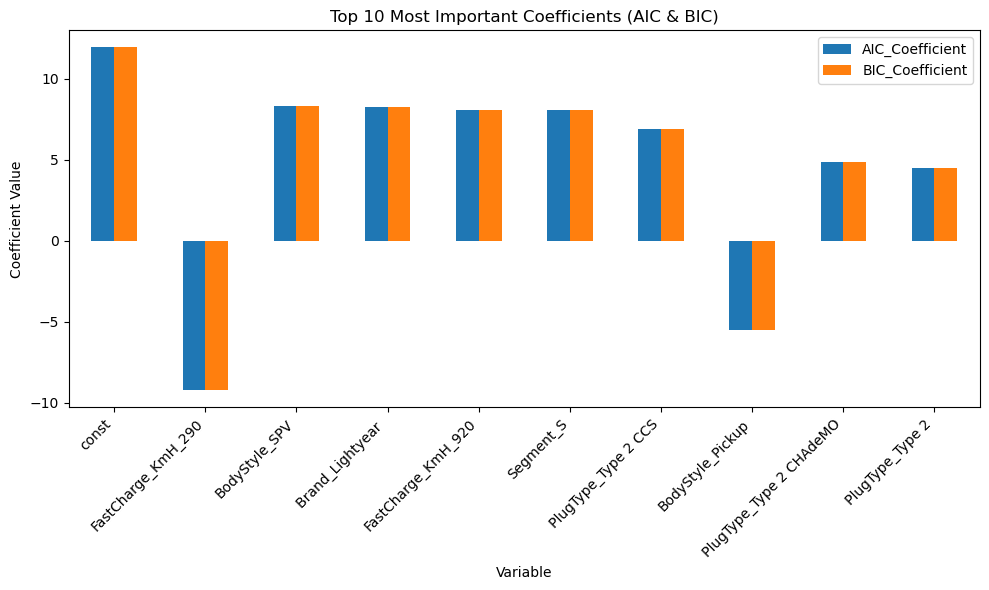

In [ ]:
# Assuming `final_model_aic` and `final_model_bic` are dictionaries or DataFrames with coefficients and p-values

# Combine coefficients from AIC and BIC models into a DataFrame
combined_coefficients = pd.DataFrame({
    'AIC_Coefficient': final_model_aic.params,
    'BIC_Coefficient': final_model_bic.params
})

# Calculate the absolute mean of the coefficients to determine importance
combined_coefficients['Mean_Importance'] = combined_coefficients.abs().mean(axis=1)

# Sort by importance and select the top 10 variables
top_10 = combined_coefficients.nlargest(10, 'Mean_Importance')

# Plot the top 10 variables
top_10[['AIC_Coefficient', 'BIC_Coefficient']].plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Most Important Coefficients (AIC & BIC)')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
top_10


,AIC_Coefficient,BIC_Coefficient,Mean_Importance
const,11.919724,11.919724,11.919724
FastCharge_KmH_290,-9.241991,-9.241991,9.241991
BodyStyle_SPV,8.276497,8.276497,8.276497
Brand_Lightyear,8.258021,8.258021,8.258021
FastCharge_KmH_920,8.077905,8.077905,8.077905
Segment_S,8.077905,8.077905,8.077905
PlugType_Type 2 CCS,6.865466,6.865466,6.865466
BodyStyle_Pickup,-5.539737,-5.539737,5.539737
PlugType_Type 2 CHAdeMO,4.841331,4.841331,4.841331
PlugType_Type 2,4.482129,4.482129,4.482129


In [13]:
data0['BodyStyle'].unique()

array(['Sedan', 'Hatchback', 'Liftback', 'SUV', 'Pickup', 'MPV', 'Cabrio',
       'SPV', 'Station'], dtype=object)

# Weighted

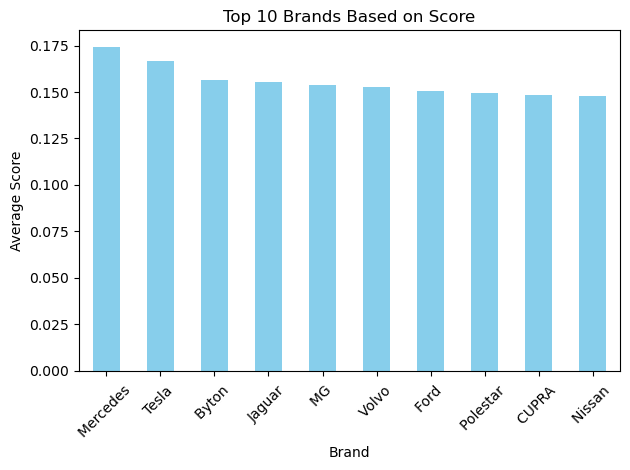

Best brands based on your criteria:
Brand
Mercedes     0.174501
Tesla        0.166684
Byton        0.156512
Jaguar       0.155141
MG           0.153936
Volvo        0.152514
Ford         0.150505
Polestar     0.149285
CUPRA        0.148438
Nissan       0.147947
Name: Score, dtype: float64


In [15]:
# Assume data0 is your DataFrame containing columns such as PriceEuro, AccelSec, Efficiency_WhKm, etc.

# Step 1: Normalize the metrics
data0['NormalizedPrice'] = -data0['PriceEuro'] / data0['PriceEuro'].max()  # Lower price is better
data0['NormalizedAccel'] = -data0['AccelSec'] / data0['AccelSec'].max()    # Lower acceleration time is better
data0['NormalizedEfficiency'] = data0['Efficiency_WhKm'] / data0['Efficiency_WhKm'].max()  # Higher efficiency is better

# Step 2: Handle top 10 important variables (combination of columns and specific values)
top_10_conditions = {
    'FastCharge_KmH_290': (data0['FastCharge_KmH'] == 290),  # FastCharge equals 290
    'BodyStyle_SPV': (data0['BodyStyle'] == 'SPV'),          # BodyStyle is SPV
    'Brand_Lightyear': (data0['Brand'] == 'Lightyear'),      # Brand is Lightyear
    'FastCharge_KmH_920': (data0['FastCharge_KmH'] == 920),  # FastCharge equals 920
    'Segment_S': (data0['Segment'] == 'S'),                 # Segment is S
    'PlugType_Type 2 CCS': (data0['PlugType'] == 'Type 2 CCS'),  # PlugType is Type 2 CCS
    'BodyStyle_Pickup': (data0['BodyStyle'] == 'Pickup'),    # BodyStyle is Pickup
    'PlugType_Type 2 CHAdeMO': (data0['PlugType'] == 'Type 2 CHAdeMO'),  # PlugType is Type 2 CHAdeMO
    'PlugType_Type 2': (data0['PlugType'] == 'Type 2')       # PlugType is Type 2
}

# Add a column for each condition, values are 0 or 1 (1 if condition is met, otherwise 0)
for var, condition in top_10_conditions.items():
    data0[var] = condition.astype(int)

# Add the constant column
data0['const'] = 1

# Step 3: Define weights for the variables
# Assign 7% weight to each top 10 variable
top_10_weights = {var: 0.07 for var in top_10_conditions.keys()}
top_10_weights['const'] = 0.07  # Include weight for 'const'

# Assign remaining 30% weight to normalized variables
other_weights = {
    'NormalizedPrice': 0.4 * 0.3,  # 40% of 30%
    'NormalizedAccel': 0.3 * 0.3,  # 30% of 30%
    'NormalizedEfficiency': 0.3 * 0.3  # 30% of 30%
}

# Combine all weights
weights = {**top_10_weights, **other_weights}

# Step 4: Calculate the overall score
data0['Score'] = 0  # Initialize the score column
for factor, weight in weights.items():
    data0['Score'] += data0[factor] * weight

# Step 5: Group by Brand and calculate the average score
brand_scores = data0.groupby('Brand')['Score'].mean().sort_values(ascending=False)

# Step 6: Visualize the results (Top 10 brands)
brand_scores.head(10).plot(kind='bar', title='Top 10 Brands Based on Score', color='skyblue')
plt.ylabel('Average Score')
plt.xlabel('Brand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the results
print("Best brands based on your criteria:")
print(brand_scores.head(10))

# Conclusion

Based on the analysis of backward selection, BIC, AIC and weighted scoring, we found Mercedes, Tesla and Byton are best suitable for NYPD.


## Significant Variables

1. Plug Type
  - 2 CHAdeMO
  - Significantly associated with acceleration performance (p = 0.002).
  - EVs with this plug type can give a higher acceleration.

1. Body Style
  - SPV (Special Purpose Vehicle):
  - Significantly associated with acceleration performance(p < 0.001).
  - Well-suited for specialized roles such as patrolling or heavy-duty operations.

2. Fast Charging Capability
  - KmH_920
  - Significantly associated with acceleration performance (p = 0.048).
  - Fast charging is a important for the operational readiness of EVs in a environment that people drive the Vehicle all day.

---

## Concerns
1. multicollinearity
- The high condition number (3.44e+17) indicates strong multicollinearity.
- Redundant predictors (e.g., multiple brands and similar charging capabilities) may give high standard errors.

1. Overfitting Concern
- With 93 predictors and only 103 observations, the model shows potential **overfitting**.
- This is with high R-squared values, which is not good for new data.

---

## Weighted Scoring Method
Using a **weighted scoring method**, the **top brands** for NYPD are:

Best brands based on your criteria:
1. Mercedes: 0.1745
2. Tesla: 0.1667
3. Byton: 0.1565
4. Jaguar: 0.1551
5. MG: 0.1539
6. Volvo: 0.1525
7. Ford: 0.1505
8. Polestar: 0.1493
9. CUPRA: 0.1484
10. Nissan: 0.1479
    
These brand are cheapest while with best performance.

---

## Recommendations for NYPD EV Selection

 1. Focus on Key Features
 Eg: Plug type and Body style.

 1. Operational Considerations
 Select EVs with fast charging capabilities, it is better to choose the speed greater than 900 KmH.

In [16]:
top_10_weights

{'const': 0.07,
 'FastCharge_KmH_290': 0.07,
 'BodyStyle_SPV': 0.07,
 'Brand_Lightyear': 0.07,
 'FastCharge_KmH_920': 0.07,
 'Segment_S': 0.07,
 'PlugType_Type 2 CCS': 0.07,
 'BodyStyle_Pickup': 0.07,
 'PlugType_Type 2 CHAdeMO': 0.07,
 'PlugType_Type 2': 0.07}

# Updated Conclusion

Based on the analysis using backward selection, AIC, BIC, and the weighted scoring method, here are the key findings and recommendations to address the objective of identifying significant variables that affect EV performance and recommending suitable brands for the NYPD:

---

## **Significant Variables**

### 1. Plug Type
- **PlugType_Type 2 CHAdeMO**:
  - Significantly associated with acceleration performance (**p = 0.002**).
  - EVs with this plug type tend to offer faster acceleration, making it a **Key Performance Indicator (KPI)** for NYPD when evaluating vehicle performance.

### 2. Body Style
- **BodyStyle_SPV (Special Purpose Vehicle)**:
  - Has a significant positive effect on acceleration (**p < 0.001**).
  - Suggests that vehicles with this body style are well-suited for specialized roles such as patrolling or heavy-duty operations.

### 3. Fast Charging Capability
- **FastCharge_KmH_920**:
  - Shows a significant effect on acceleration (**p = 0.048**).
  - Fast charging is a critical metric for ensuring the **operational readiness** of EVs in a demanding environment like NYPD operations.

---

## **Multicollinearity Concern**
- The high condition number (**3.44e+17**) indicates **strong multicollinearity** among independent variables.
- Redundant predictors (e.g., multiple brands and similar charging capabilities) may inflate standard errors, affecting the reliability of estimates.

---

## **Overfitting Concern**
- With 93 predictors and only 103 observations, the model shows potential **overfitting**, limiting generalizability.
- This is reflected in high R-squared values that may not translate well to new data.

---

## **Weighted Scoring Method**
Using a **weighted scoring method** that considers the importance of key variables (plug type, body style, and charging capabilities) alongside operational metrics such as price, acceleration, and efficiency, the **top brands** identified for NYPD are:

### **Best Brands Based on Score**
1. **Mercedes**: 0.1745
2. **Tesla**: 0.1667
3. **Byton**: 0.1565
4. **Jaguar**: 0.1551
5. **MG**: 0.1539
6. **Volvo**: 0.1525
7. **Ford**: 0.1505
8. **Polestar**: 0.1493
9. **CUPRA**: 0.1484
10. **Nissan**: 0.1479

These brands demonstrate a strong balance of performance, operational suitability, and cost-effectiveness.

---

## **Recommendations for NYPD EV Selection**

### 1. **Focus on Key Features**
- **Plug Type**: Prioritize EVs with **PlugType_Type 2 CHAdeMO** for better acceleration.
- **Body Style**: Consider **BodyStyle_SPV** for specialized roles requiring high performance.

### 2. **Operational Considerations**
- Select EVs with fast charging capabilities, especially rates exceeding **900 KmH**, to minimize downtime.

### 3. **Data and Model Improvement**
- Address multicollinearity by applying methods such as **Variance Inflation Factor (VIF)** analysis or feature selection to reduce redundant variables.
- Expand the dataset to improve model reliability and better capture relationships between variables and EV performance.

---

## **Conclusion**
By combining insights from variable selection methods and the weighted scoring analysis, this study identifies the top-performing brands and significant factors influencing EV performance. **Mercedes, Tesla, and Byton** emerge as leading candidates for NYPD's EV procurement, offering a balanced mix of performance, efficiency, and cost. These recommendations provide a **data-driven foundation** to guide NYPD in aligning its operational goals with suitable EV choices.

